In [431]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as kpss
from statsmodels.tsa.seasonal import STL
import pmdarima as pm
import itertools
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

# Домашнее задание

Проведите изначальную предобработку

In [469]:
def diff(data, interval):
    new = []
    for i in range(interval, len(data)):
        new.append(data[data.columns[0]][i]-data[data.columns[0]][i-interval])
    #df2 = data.assign(sum = new)
    return new

def inverse_difference(last_ob, value):
    source = []
    source.append(last_ob[last_ob.columns[0]][len(last_ob)-len(value)-1])
    for i in range(len(value)):
        source.append(value[last_ob.columns[0]][i] + last_ob[last_ob.columns[0]][i])
    df_source = last_ob.assign(sum = source)
    return df_source



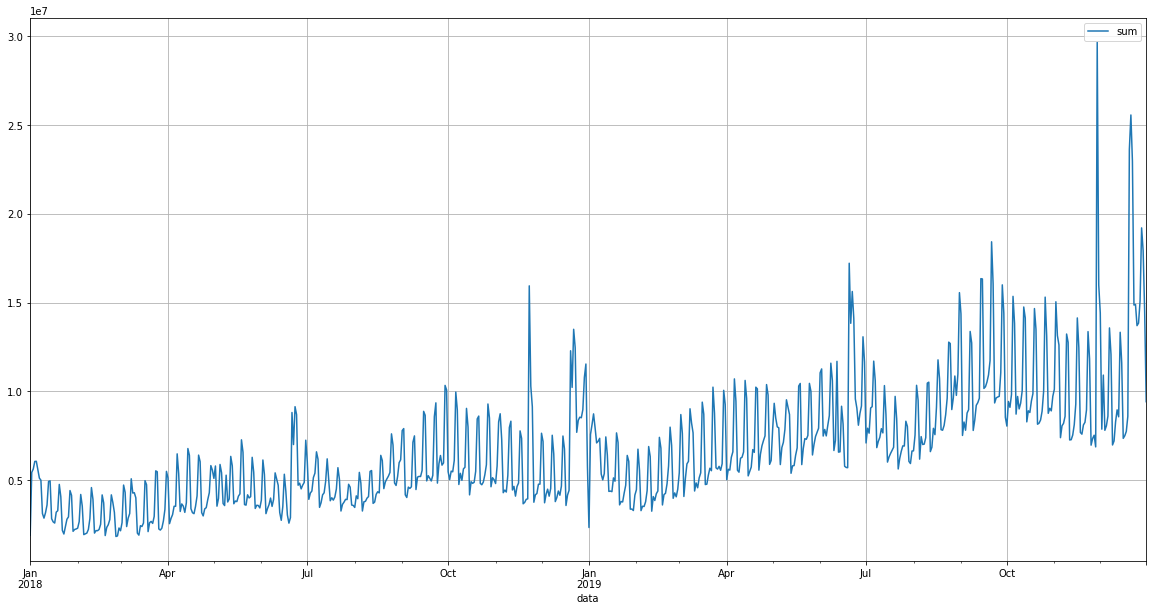

In [470]:
df = pd.read_csv('ряды.csv')
df['data'] = df.data.apply(lambda x: x[0:10])
df['data'] = pd.to_datetime(df.data, errors='coerce')
df.set_index('data', inplace=True)
df.plot(figsize=(20,10),grid = True)

In [501]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20, 10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

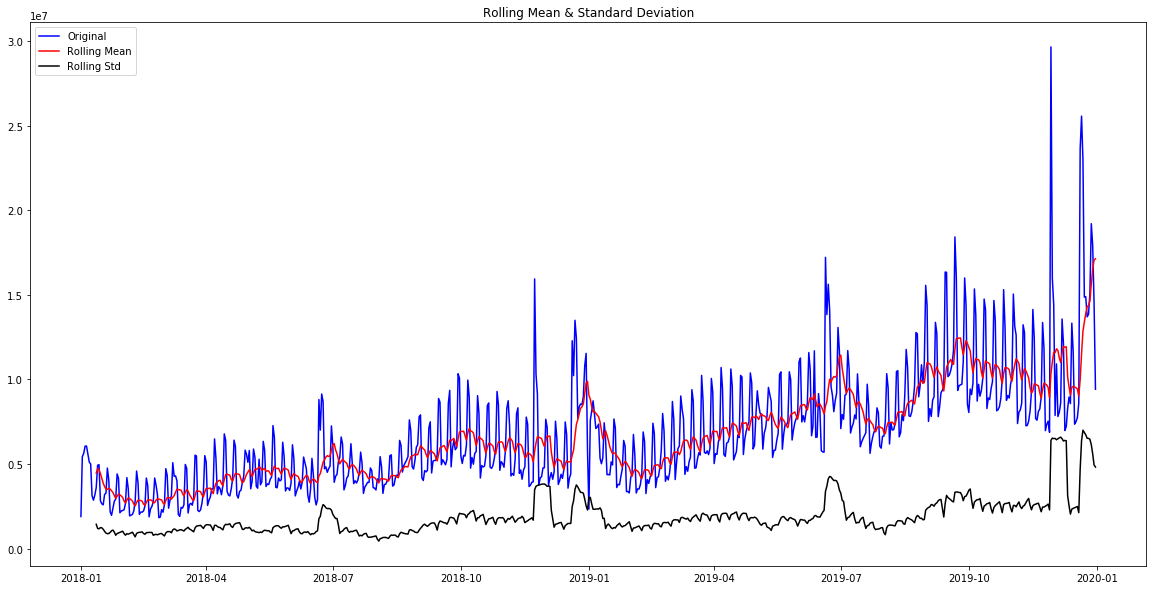

Results of Dickey-Fuller Test:
Test Statistic                   0.166271
p-value                          0.970305
#Lags Used                      20.000000
Number of Observations Used    709.000000
Critical Value (1%)             -3.439607
Critical Value (5%)             -2.865625
Critical Value (10%)            -2.568945
dtype: float64


In [502]:
test_stationarity(df['sum'])

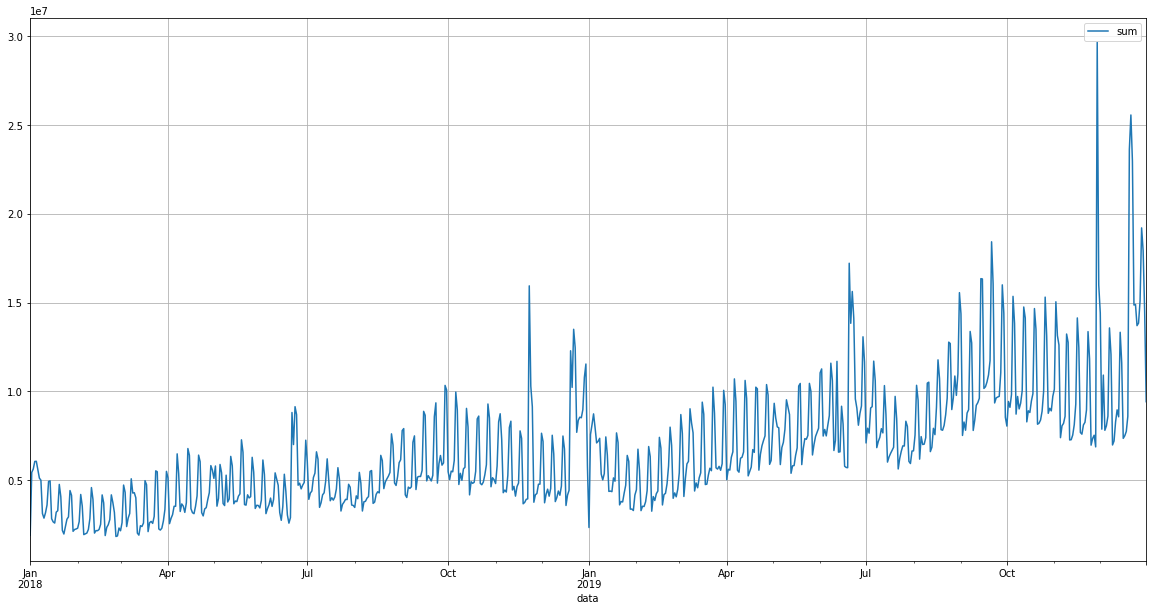

In [492]:
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()

df.plot(figsize=(20,10),grid = True)

#plt.vlines('2018-12-23',100000,20000000)
#plt.vlines('2019-12-23',100000,30000000)
#plt.vlines('2019-11-29',100000,30000000)
#plt.vlines('2018-11-23',100000,30000000)


На данном графике проселживается тренд и сезонность.

сезонности:
* ежегодные (пики в ноябре) - 365 дней
* недельные - 7 дней

### Избавимся от ежегодной сезонности путем сезонного дифференцирования

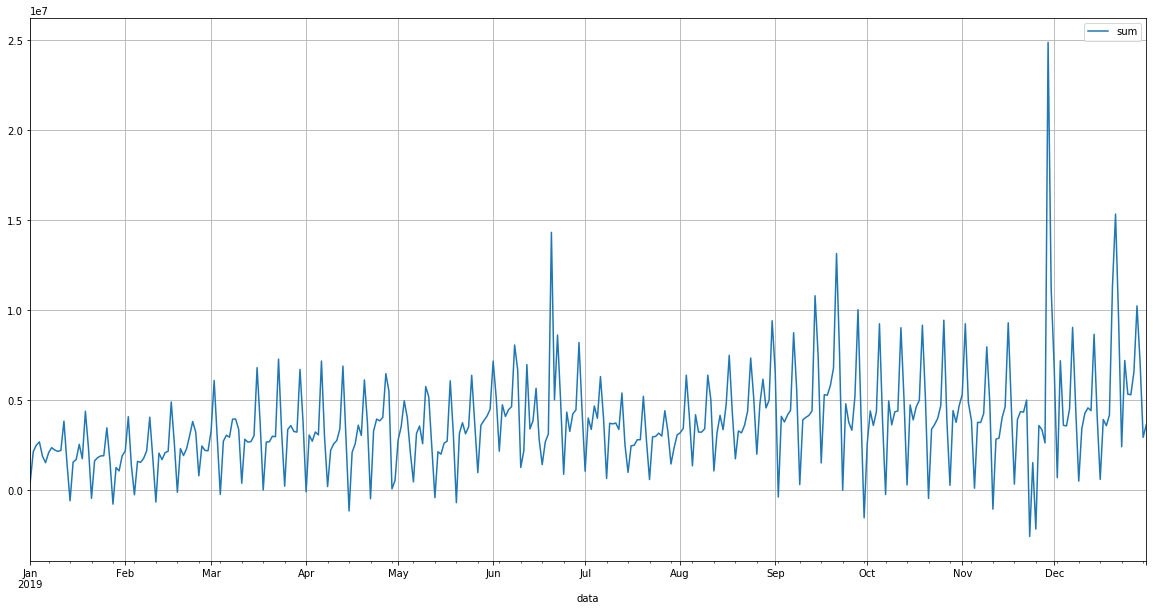

In [616]:
df1diff = df.diff(365).dropna()
df1diff.plot(figsize=(20,10),grid = True)
#plt.vlines('2019-12-20',100000,30000000)
#plt.vlines('2019-6-20',100000,30000000)



### Избавимся от недельной сезонности

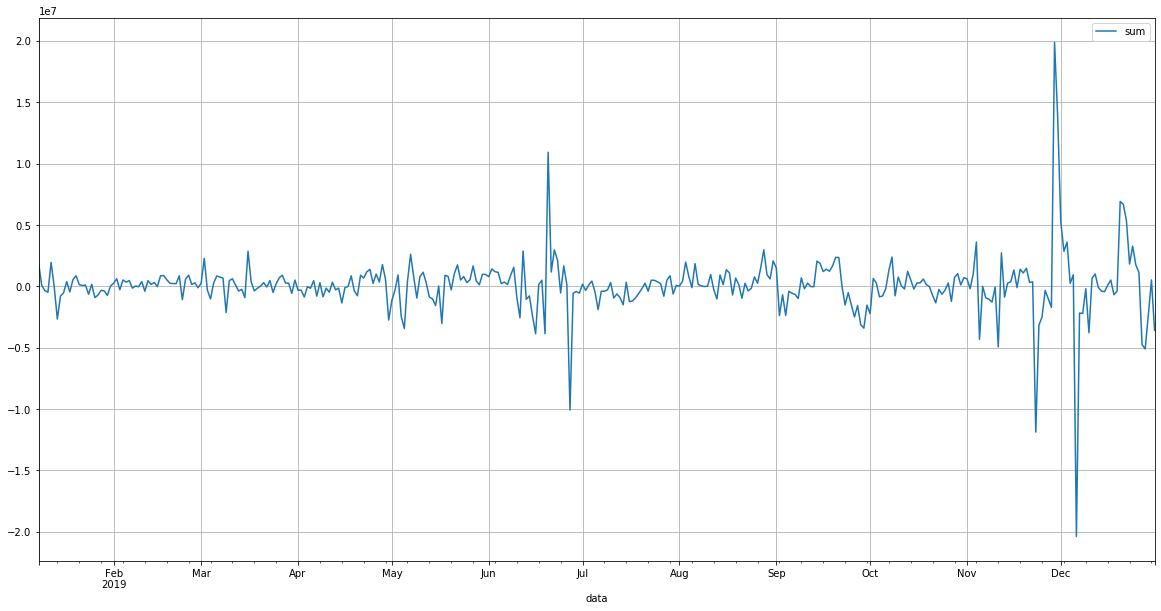

In [495]:
b = df1diff.diff(periods=7).dropna()
b.plot(figsize=(20,10),grid = True)
#plt.vlines('2019-10-13',-10000000,13000000)
#plt.vlines('2019-10-20',-10000000,13000000)
#plt.vlines('2019-10-27',-10000000,13000000)
#plt.vlines('2019-10-6',-10000000,13000000)


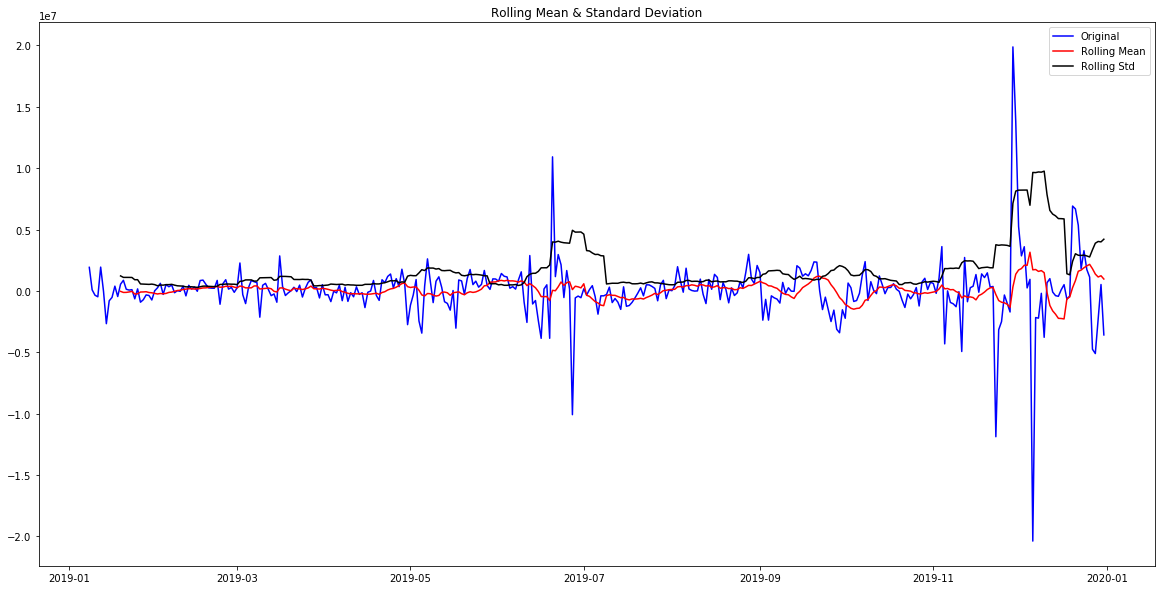

Results of Dickey-Fuller Test:
Test Statistic                -7.563493e+00
p-value                        2.967339e-11
#Lags Used                     1.400000e+01
Number of Observations Used    3.430000e+02
Critical Value (1%)           -3.449560e+00
Critical Value (5%)           -2.870004e+00
Critical Value (10%)          -2.571279e+00
dtype: float64


In [504]:
test_stationarity(b['sum'])

In [511]:
print(sm.tsa.stattools.kpss(b, regression='c')[0:2])


(0.03228067545946275, 0.1)


Ряд стационарен после сезонных преобразований

Так же ряд стационарен после 1 дифференцирования

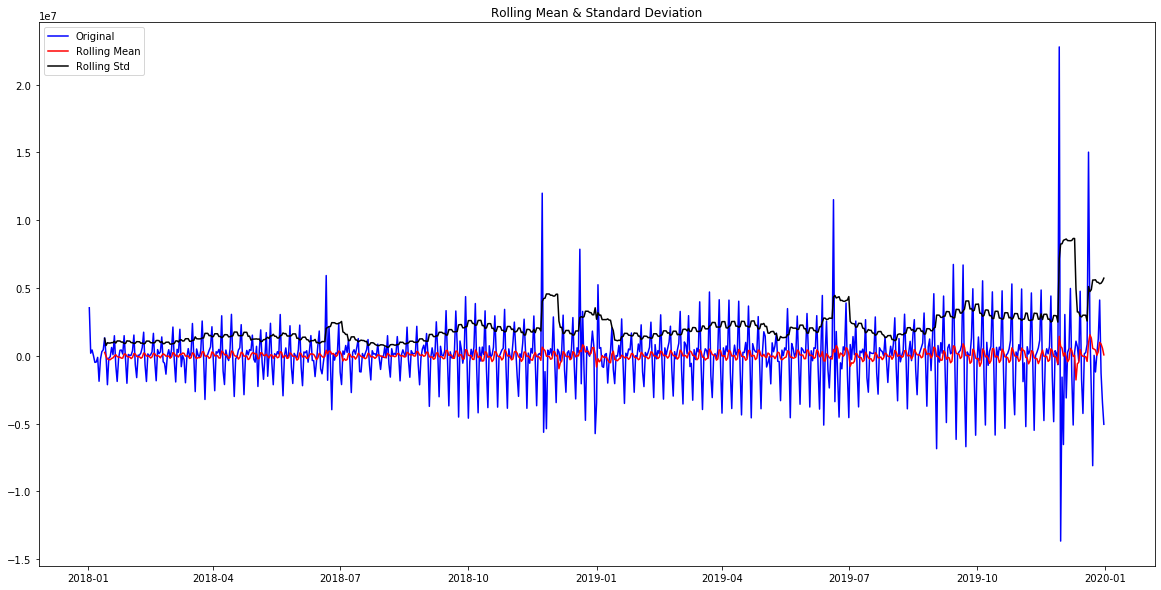

Results of Dickey-Fuller Test:
Test Statistic                -9.289616e+00
p-value                        1.189503e-15
#Lags Used                     2.000000e+01
Number of Observations Used    7.080000e+02
Critical Value (1%)           -3.439620e+00
Critical Value (5%)           -2.865631e+00
Critical Value (10%)          -2.568948e+00
dtype: float64


In [729]:
test_stationarity(df['sum'].diff().dropna())

# Определите каике d и D надо взять

#### Для модели ARIMA

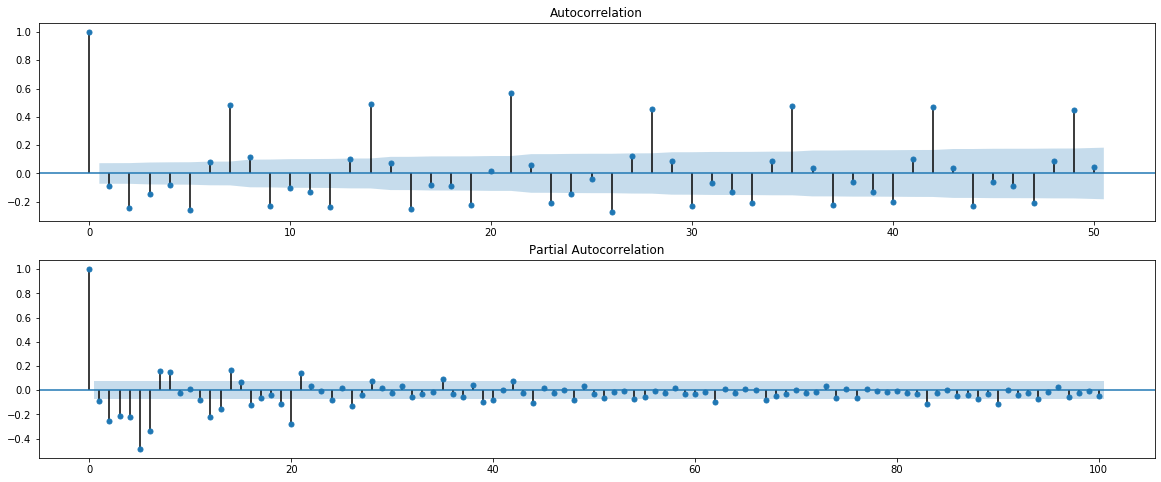

In [579]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.diff().dropna().values.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.diff().dropna(), lags=100, ax=ax2)

#### Для модели SARIMA

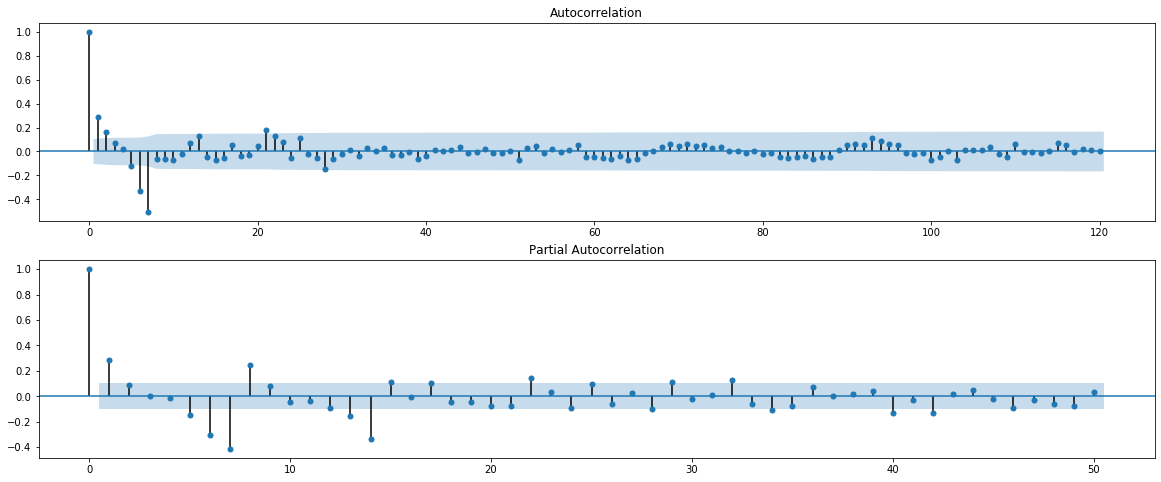

In [621]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1diff.diff(7).dropna().values.squeeze(), lags=120, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1diff.diff(7).dropna(), lags=50, ax=ax2)

In [659]:
ARIMA_data_model = df[:'2019-09-01']
SARIMA_data_model = df1diff[:'2019-09-01']

model_ARIMA = sm.tsa.ARIMA(ARIMA_data_model, order=(7,1,5)).fit(full_output=False, disp=0)
model_SARIMA = sm.tsa.SARIMAX(SARIMA_data_model, order=(6,1,5), seasonal_order=(2,1,2,7)).fit(full_output=False, disp=0)


In [660]:
pred = model_ARIMA.predict('2019-09-01','2020-02-01', typ='levels')
pred2 = model_SARIMA.predict('2019-09-01','2020-02-01', typ='levels')

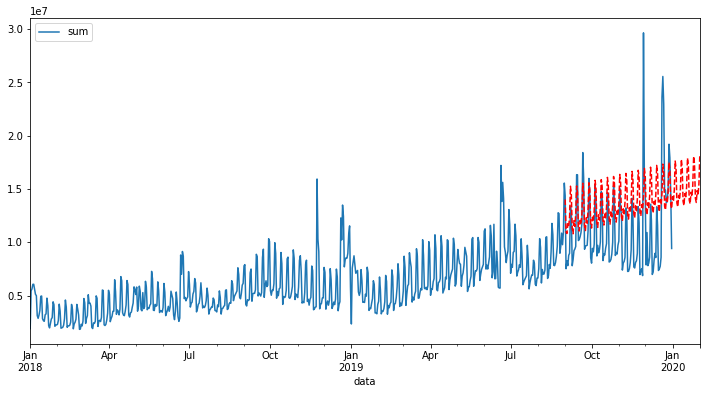

In [661]:
df.plot(figsize=(12,6))
pred.plot(style='r--')

In [726]:
model_ARIMA.aic

18782.265226550215

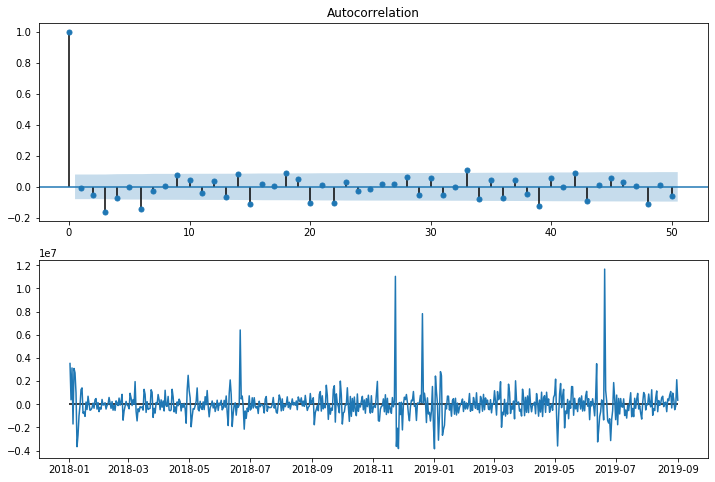

In [718]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax2.plot(model_ARIMA.resid)
ax2.hlines(0,'2018-01-01','2019-09-01')
sm.graphics.tsa.plot_acf(model_ARIMA.resid, lags=50, ax=ax1)
plt.show()

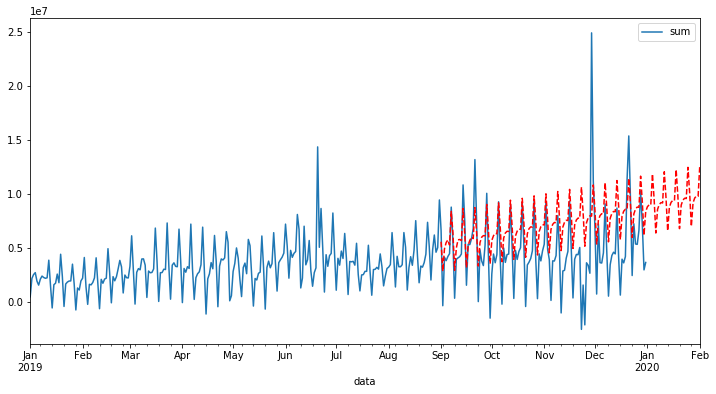

In [689]:
df1diff.plot(figsize=(12,6))
pred2.plot(style='r--')

In [727]:
model_SARIMA.aic

7302.684941734155

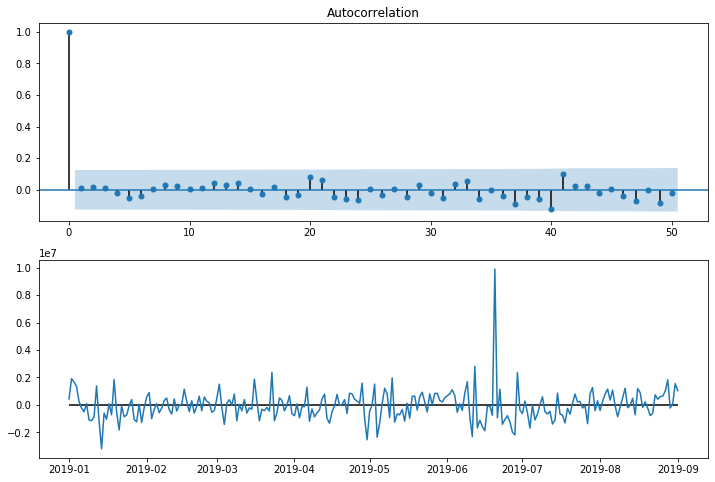

In [725]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax2.plot(model_SARIMA.resid)
ax2.hlines(0,'2019-01-01','2019-09-01')
sm.graphics.tsa.plot_acf(model_SARIMA.resid, lags=50, ax=ax1)
plt.show()

# Вывод:

Остатки гомоскедастичны,на них имеются выбросы в виде сезонностей. Есть два пика в данных '2019-11-29' и '2018-11-23' которые не подходят под годовую сезонность(371 день разницы между ними, см. график ниже) из-за малого количества данных сложно сказать, с чем связана разница в 6 дней, так же из-за малого количества данных, убирая годовую сезонность, мы теряем половинну ряда, предположу, что модель из-за этого плохо обучается. 

Но если делат вывод по построеным моделям, конечно модель SARIMA справляется лучше, т.к. в нашем ряду есть сезонности.

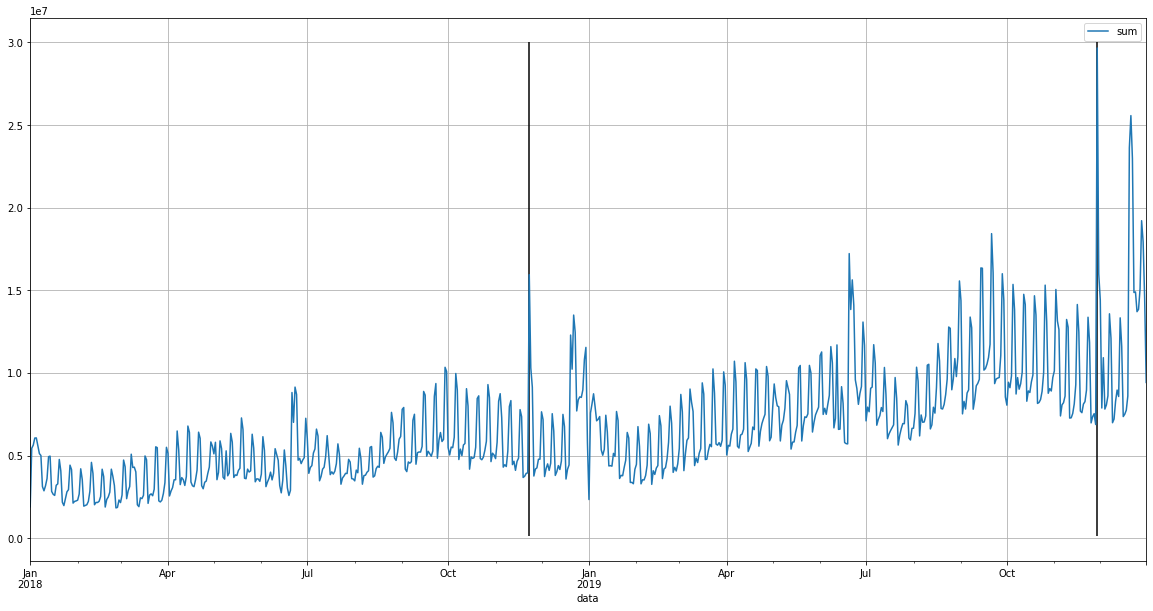

In [732]:
df.plot(figsize=(20,10),grid = True)
plt.vlines('2019-11-29',100000,30000000)
plt.vlines('2018-11-23',100000,30000000)